### Hyperparameters

In [1]:
from keras.callbacks import EarlyStopping

# Stopping training when validation loss does not improve
callbacks = [EarlyStopping(monitor="val_accuracy", patience=5),
             EarlyStopping(monitor="val_loss", patience=5)]

EPOCHS = 20
BATCH_SIZE = 32
EMBEDDING_DIM = 100

### Loading data

In [2]:
from data.uci_news_aggregator.dataloader import load_full_dataset
import pandas as pd

dataset = load_full_dataset()

train = dataset["train"]
val = dataset["dev"]
test = dataset["test"]

# Combining data for later use
combined_data = pd.concat([train, val, test]).reset_index(drop=True)

# Separating texts and labels
X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

In [3]:
X_train[0]

'Lisa Niemi Marries Albert DePrisco'

In [4]:
y_train[0]

0

### Preprocessing data

In [5]:
from collections import Counter
import math

num_words = Counter()
for text in combined_data["text"]:
    sentences = text.split(" ")
    for word in sentences:
        num_words[word] += 1
# Shorten the number of the words to improve training
num_words = len(num_words) / 20
num_words = math.ceil(num_words / 1000) * 1000

In [6]:
from keras.preprocessing.text import Tokenizer

# Tokenizing texts
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>", filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(combined_data["text"].tolist())

# Converting texts to sequences
print("Converting texts to sequences...")
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

Converting texts to sequences...


In [7]:
X_train[0]

[6927, 1, 1682, 1, 1]

In [8]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Deciding embedding vector length
maxlen = (int(np.ceil(np.mean([len(text.split()) for text in combined_data.text]))))

# Padding sequences with zeros until they reach a certain length
print("Padding sequences...")
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

Padding sequences...


In [9]:
X_train[0]

array([   0,    0,    0,    0,    0, 6927,    1, 1682,    1,    1])

In [10]:
from keras.utils.np_utils import to_categorical

# Number of unique classes in the dataset
num_classes = len(np.unique(y_train))

# One-hot encoding of labels
print("One-hot encoding labels...")
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

One-hot encoding labels...


In [11]:
y_train[0]

array([1., 0., 0., 0.], dtype=float32)

# Training with multiclass dataset

In [12]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)
print('num_words:', num_words)
print('maxlen:', maxlen)
print('num_classes:', num_classes)

X_train shape: (337935, 10)
X_val shape: (42242, 10)
X_test shape: (42242, 10)
y_train shape: (337935, 4)
y_val shape: (42242, 4)
y_test shape: (42242, 4)
num_words: 9000
maxlen: 10
num_classes: 4


In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.optimizers import adam_v2

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=adam_v2.Adam(learning_rate=1e-4), metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           900000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 10, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 917,156
Trainable params: 917,156
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/20
10561/10561 [==============================] - 190s 18ms/step - loss: 0.4764 - accuracy: 0.8241 - val_loss: 0.2550 - val_accuracy: 0.9135
Epoch 2/20
10561/10561 [==============================] - 183s 17ms/step - loss: 0.2474 - accuracy: 0.9145 - val_loss: 0.2237 - val_accuracy: 0.9225
Epoch 3/20
10561/10561 [==============================] - 223s 21ms/step - loss: 0.2212 - accuracy: 0.9227 - val_loss: 0.2170 - val_accuracy: 0.9248
Epoch 4/20
10561/10561 [==============================] - 271s 26ms/step - loss: 0.2108 - accuracy: 0.9256 - val_loss: 0.2148 - val_accuracy: 0.9243
Epoch 5/20
10561/10561 [==============================] - 269s 25ms/step - loss: 0.2051 - accuracy: 0.9279 - val_loss: 0.2142 - val_accuracy: 0.9244
Epoch 6/20
10561/10561 [==============================] - 270s 26ms/step - loss: 0.2002 - accuracy: 0.9291 - val_loss: 0.2128 - val_accuracy: 0.9249
Epoch 7/20
10561/10561 [==============================] - 266s 25ms/step - loss: 0.1969 - accuracy: 0.9303

In [19]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

1321/1321 [==============================] - 5s 4ms/step - loss: 0.2061 - accuracy: 0.9287
Validation loss: 0.20609325170516968
Validation accuracy: 0.9286965727806091


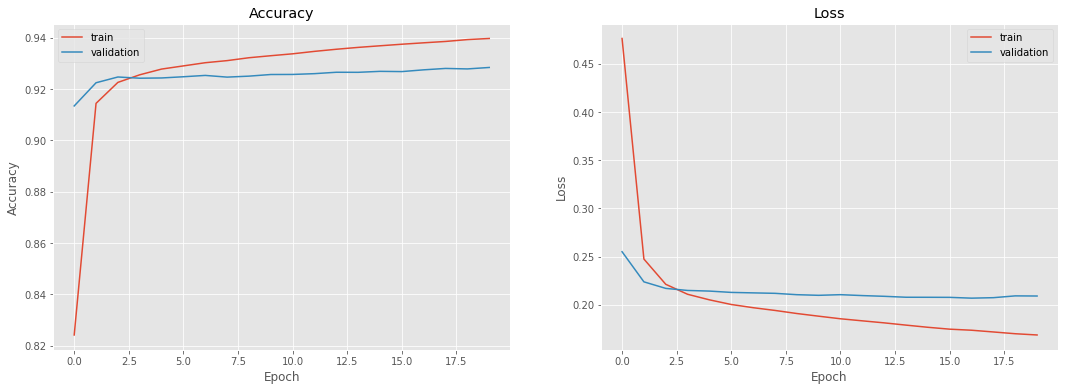

In [20]:
from utils.visualization import plot_history

plot_history(history, save=False, show=True)